### 다변량 선형 회귀

In [1]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)


In [4]:
# 데이터 가져오기
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

bostonDF = pd.DataFrame(data, columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"])
bostonDF['PRICE'] = target
print(bostonDF.head())

print(data)
print(target)

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  
[[6.320e-03 1.800e+01 2.310e+00 ... 1.530e+01 3.969e+02 4.980e+00]
 [2.731e-02 0.000e+00 7.070e+00 ... 1.780e+01 3.969e+02 9.140e+00]
 [2.729e-02 0.000e+00 7.070e+00 ... 1.780e+01 3.928e+02 4.030e+00]
 ...
 [6.076e-02 0.000e+00 1.193e+01 ... 2.100e+01 3.969e+02 5.640e+00]
 [1.096e-01 0.000e+00 1.193e+01 ... 2.100e+01 3.934e+02 6.480e+00]
 [4.741e-02

#### 보스톤 주택 가격을 다변량 선형 회귀를 이용해서 예측

In [5]:
# 데이터 가져오기
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
print(y_target)
print(X_data)

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: PRICE, Length: 506, dtype: float64
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
50

In [7]:
# 훈련 데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split

# 데이터를 7:3 으로 분리 - 절대적인 비율은 아님
X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# 8:2 나 9:1등 도 사용해 보고 경진대회에서는 100% 사용하는 것도 고려
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


In [8]:
# 회귀 모델을 생성하고 훈련
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train ,y_train)

LinearRegression()

In [11]:
# 테스트 데이터로 예측해서 평가까지
y_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_preds)
#mse는 제곱을 하므로 실제 데이터보다 스케일 큰 경우가 많음
#mse를 제곱근해서 많이 사용 : RMSE
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2score = r2_score(y_test, y_preds)

print("MSE :", mse)
print("RMSE :", rmse)
print("R2 :", r2score)

MSE : 17.29691590790215
RMSE : 4.158956107955715
R2 : 0.7572263323138921


In [12]:
# 회귀 계수와 절편 값을 확인
print('절편:',lr.intercept_)
print('기울기:', np.round(lr.coef_, 1)) #다변량 회귀라 값이 여러개 나옴

절편: 40.995595172164336
기울기: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


### score.csv 파일의 데이터를 이용해서 iq 와 academy, game, tv를 이용한 시간을 이용해서 score를 예측

In [15]:
df = pd.read_csv("./data/data/data/score.csv", encoding="ms949")
df.head()

,name,score,iq,academy,game,tv
0,A,90,140,2,1,0
1,B,75,125,1,3,3
2,C,77,120,1,0,4
3,D,83,135,2,3,2
4,E,65,105,0,4,4


In [16]:
import statsmodels.formula.api as sm

result = sm.ols(formula = 'score ~ iq + academy + game + tv', data = df).fit()
print("절편과 기울기 : ", result.params)
print("유의 확률 : ", result.pvalues)
print("결정 계수 : ", result.rsquared)

절편과 기울기 :  Intercept    23.299232
iq            0.468422
academy       0.717901
game         -0.838955
tv           -1.385408
dtype: float64
유의 확률 :  Intercept    0.117508
iq           0.003376
academy      0.534402
game         0.131001
tv           0.184269
dtype: float64
결정 계수 :  0.9608351062148871


In [17]:
# IQ가 130이고 학원을 3개 다니고 게임을 2시간, tv를 1시간 보는 학생의 예상 점수는?
y = result.params.Intercept + 130*result.params.iq + 3*result.params.academy + 2*result.params.game+1*result.params.tv
print("예측점수:" , y)

예측점수: 83.28448678034155


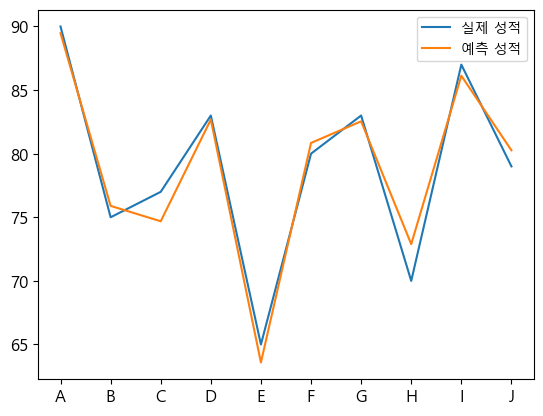

In [18]:
# 예측 값과 실제 값의 시각화 - 결정 계수가 높으므로 오차가 별로 없음
plt.figure()
plt.plot(df['score'], label='실제 성적')
plt.plot(result.predict(), label='예측 성적')
plt.xticks(range(0,10,1),df['name'])
plt.legend();
plt.show()

In [21]:
#VIF(분산 팽창 요인) 출력
X = df.drop(['score','name'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor features
0        31.2       iq
1        13.4  academy
2         3.1     game
3         7.8       tv


In [22]:
#VIF(분산 팽창 요인) 출력
X = df.drop(['score','name', 'iq'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor features
0         1.5  academy
1         2.7     game
2         2.2       tv


In [23]:
# iq를 빼고 다시 진행
result = sm.ols(formula = 'score ~ academy + game + tv', data = df).fit()
print("절편과 기울기 : ", result.params)
print("유의 확률 : ", result.pvalues)
print("결정 계수 : ", result.rsquared)

절편과 기울기 :  Intercept    84.550774
academy       1.212952
game         -0.589089
tv           -3.255293
dtype: float64
유의 확률 :  Intercept    0.000084
academy      0.643589
game         0.603234
tv           0.140620
dtype: float64
결정 계수 :  0.7464068030954777


In [24]:
# academy를 빼고 다시 진행
result = sm.ols(formula = 'score ~ iq + game + tv', data = df).fit()
print("절편과 기울기 : ", result.params)
print("유의 확률 : ", result.pvalues)
print("결정 계수 : ", result.rsquared)

절편과 기울기 :  Intercept    25.047397
iq            0.473669
game         -0.903660
tv           -1.823124
dtype: float64
유의 확률 :  Intercept    0.071898
iq           0.001412
game         0.082017
tv           0.020863
dtype: float64
결정 계수 :  0.957351876527423


In [26]:
#### 보스톤 주택 가격에 Ridge 모델 적용
from sklearn.linear_model import Ridge

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

In [28]:
from sklearn.model_selection import cross_val_score
# 적용할 규제 값
# 규제 : 불필요한걸 빼거나 줄이거나 하는 것
alphas = [0 , 0.1 , 1 , 10 , 100]

for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


### 비선형 회귀

## knn

In [29]:
from sklearn.neighbors import KNeighborsRegressor
# 거리를 가지고 가중 평균을 구해서 예측
# uniform을 설정하면 일반 평균
regressor = KNeighborsRegressor(n_neighbors = 3, weights = "distance")

X_train = [
  [0.5, 0.2, 0.1],
  [0.9, 0.7, 0.3],
  [0.4, 0.5, 0.7],
    [0.2, 0.3, 0.5]
]

y_train = [5.0, 6.8, 9.0, 4.3]

regressor.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3, weights='distance')

In [30]:
X_test = [
  [0.2, 0.1, 0.7],
  [0.4, 0.7, 0.6]
]

pred = regressor.predict(np.array(X_test))
print(pred)



[5.893 7.324]


### Decision Tree를 이용한 회귀 및 시각화


In [31]:
# 샘플 데이터를 생성
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

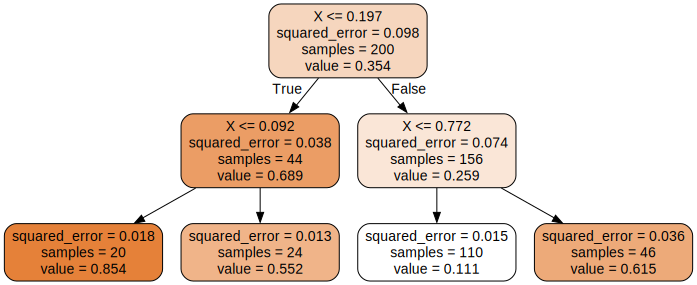

In [33]:
# 트리 시각화
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg,
        out_file="decision_tree.dot",
        feature_names=["X"],
        class_names="y",
        rounded=True,
        filled=True
    )

# 화면 출력
with open('decision_tree.dot') as f:
    dot_graph = f.read()
    
src = Source(dot_graph)
src

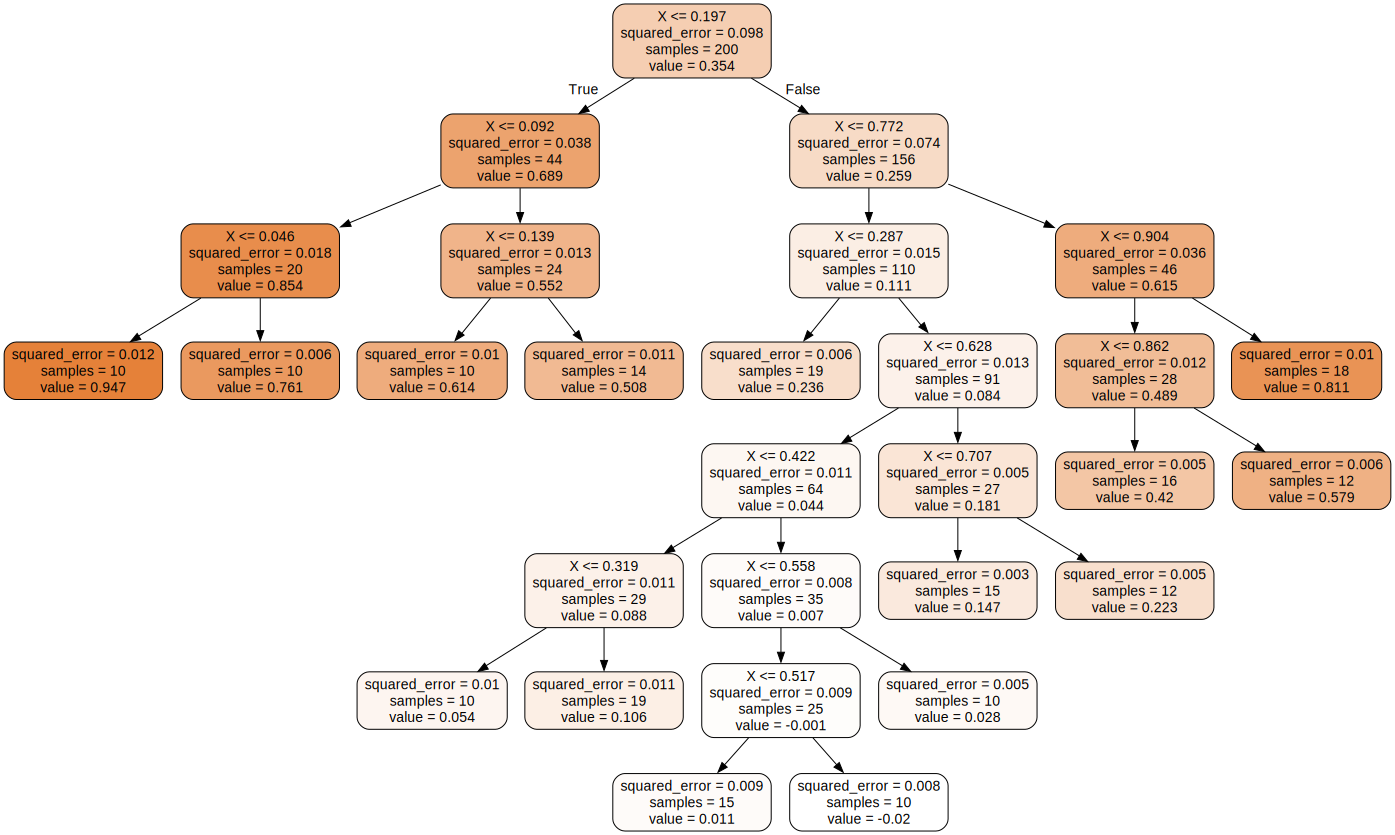

In [35]:
from sklearn.tree import DecisionTreeRegressor
# 터미널(자식이 없는 노드 - leaf node)의 개수가 10이상이어야 한다는 제약
# min_samples_leaf를 설정하게 되면 각 터미널의 depth가 일정하지 않을 수 있음
tree_reg = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg.fit(X, y)

# 트리 시각화
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg,
        out_file="decision_tree.dot",
        feature_names=["X"],
        class_names="y",
        rounded=True,
        filled=True
    )

# 화면 출력
with open('decision_tree.dot') as f:
    dot_graph = f.read()
    
src = Source(dot_graph)
src

### SVM을 이용한 회귀

In [46]:
#시드 고정 후 가우시안 분포를 따르는 데이터셋을 만듭니다.
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m,1)
# ravel은 차원을 하나 줄이는 역할을 수행해주는 함수
# X 때문에 2차원 배열로 만들어지는 타겟은 1차원 배열이어야 해서 차원을 수정
# flatten 이나 reshape를 이용해서 조절을 해도 됨
y = (4+3*X+np.random.randn(m,1)).ravel()
print(y)

X_train = X[:40]
X_test = X[40:]

y_train = y[:40]
y_test = y[40:]

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_train,y_train)

[ 6.986  9.876  8.276  7.291  3.458  4.216  3.888 10.254  7.95   6.485
  4.448  9.434  8.318  5.886  6.122  6.032  4.986  6.839  6.923  6.723
  7.192  4.651  4.647  5.002  7.549 10.067  5.126  8.089  7.916  3.634
  8.007  6.561  4.354 11.258  7.174  9.672  5.915  4.287  8.197  4.653
  4.513  7.328  5.684  8.938  4.744  7.473  6.786  7.449  6.751  5.622]


LinearSVR(epsilon=1.5, random_state=42)

In [47]:
# 예측 및 결과 비교
y_pred = svm_reg.predict(X_test)
print(y_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

[4.513 7.328 5.684 8.938 4.744 7.473 6.786 7.449 6.751 5.622]
[4.211 6.489 3.676 9.018 5.046 7.511 5.369 6.641 6.804 4.594]
0.9299366061913275


In [49]:
# 비선형 데이터 생성
m = 100
X = 2* np.random.rand(m,1) -1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m,1) / 10).ravel()

X_train = X[:80]
X_test = X[80:]

y_train = y[:80]
y_test = y[80:]

0.22592554998398115


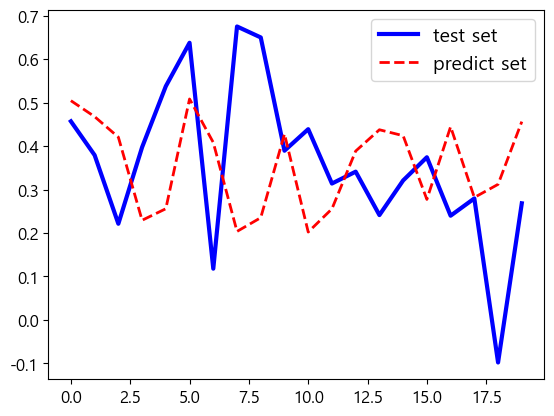

[ 0.457  0.379  0.221  0.397  0.538  0.638  0.118  0.675  0.65   0.389
  0.439  0.314  0.341  0.241  0.321  0.374  0.24   0.28  -0.098  0.268]
[0.505 0.468 0.421 0.229 0.256 0.509 0.408 0.204 0.235 0.428 0.202 0.256
 0.389 0.438 0.424 0.277 0.445 0.282 0.312 0.456]


In [58]:
# 선형 SVM 적용
svm_reg = LinearSVR(epsilon=0.1, random_state=42)
svm_reg.fit(X_train,y_train)

# 예측 및 결과 비교
y_pred = svm_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()

print(y_test)
print(y_pred)

0.13436220922451295


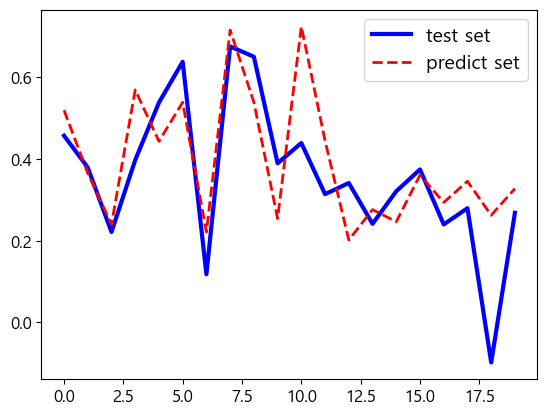

[ 0.457  0.379  0.221  0.397  0.538  0.638  0.118  0.675  0.65   0.389
  0.439  0.314  0.341  0.241  0.321  0.374  0.24   0.28  -0.098  0.268]
[0.519 0.365 0.24  0.569 0.443 0.539 0.221 0.715 0.539 0.254 0.724 0.444
 0.202 0.276 0.246 0.36  0.294 0.345 0.262 0.327]


In [57]:
# 비선형 SVM 적용

from sklearn.svm import SVR
# 샘플 데이터를 2차 방정식으로 만들었기 때문에 degree가 2인 경우가 제일 잘 맞음
# 샘플 데이터를 알지 못한다면 degree는 하이퍼 파라미터 튜닝을 해서 구해야 함
svm_reg = SVR(kernel="poly", degree=2, epsilon=0.1)
svm_reg.fit(X_train,y_train)

# 예측 및 결과 비교
y_pred = svm_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()

print(y_test)
print(y_pred)